In [1]:
# To import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle 
from openTSNE import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# To download the Punkt tokenizer model
nltk.download('punkt')

# To download the list of stopwords
nltk.download('stopwords')

# To download the WordNet lexical database
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BP927MR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BP927MR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BP927MR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# To load the required dataset
df = pd.read_csv('AI_Human.csv', low_memory = False)

# To display the dimensions of the DataFrame
print(f"(rows, columns): {df.shape}")

(rows, columns): (487235, 2)


C:\Users\BP927MR\AppData\Local\Temp\ipykernel_19612\1586712625.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x = class_counts.index, y = class_counts.values, palette = 'viridis', edgecolor = 'black')


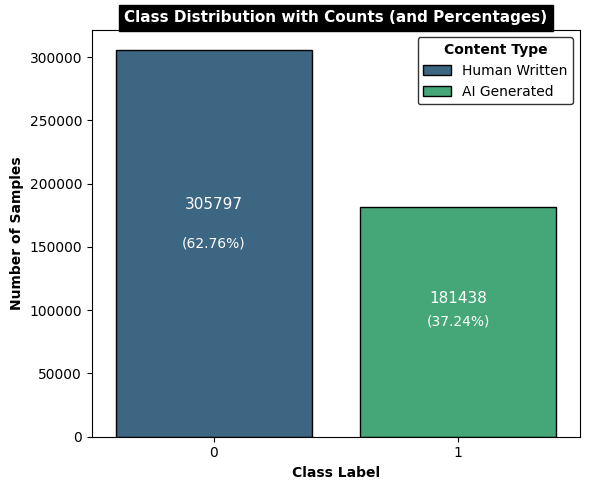

In [4]:
# To calculate the counts and percentages for both classes
class_counts = df['generated'].value_counts()
total_count = len(df)
class_percentages = (class_counts / total_count) * 100

# To visualize the barplot
plt.figure(figsize = (6, 5))
bar_plot = sns.barplot(x = class_counts.index, y = class_counts.values, palette = 'viridis', edgecolor = 'black')

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height() / 2 + 0.1 * p.get_height()),
                      ha = 'center', va = 'center', 
                      fontsize = 11, color = 'white')

for i, count in enumerate(class_counts):
    percentage = class_percentages[i]
    bar_plot.annotate(f'({percentage:.2f}%)', 
                      (i, count / 2),
                      ha = 'center', va = 'center',
                      fontsize = 10, color = 'white')

legend_labels = ['Human Written', 'AI Generated']
colors = bar_plot.patches
handles = [plt.Rectangle((0, 0), 1, 1, facecolor = colors[i].get_facecolor(), edgecolor = 'black') for i in range(len(legend_labels))]

plt.xlabel('Class Label', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('Number of Samples', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('Class Distribution with Counts (and Percentages)', fontdict = {'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.xticks(ticks = class_counts.index, labels = [0, 1])
plt.legend(handles, legend_labels, title = 'Content Type', title_fontproperties = {'weight': 'bold'}, loc = 'upper right', edgecolor = 'black')

plt.tight_layout()
plt.show()

In [5]:
# To define a function for text preprocessing
def preprocess_text(text):

    # To convert the text to lowercase
    text = text.lower()

    # To remove HTML tags from the text
    text = re.sub('<.*?>', '', text)

    # To remove URLs from the text
    text = re.sub(r'http\S+', '', text)

    # To remove special characters and numbers from the text
    text = re.sub('[^a-zA-Z\s]', '', text)

    # To tokenize the text
    tokens = word_tokenize(text)

    # To remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # To lemmatize each token
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # To rejoin tokens into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# To apply the function to the 'text' column
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [6]:
# To split the dataset into training and test sets
cols = ['preprocessed_text', 'generated']
train_indices, test_indices = train_test_split(df.index, test_size = 0.2, random_state = 42)

train_df = df.loc[train_indices, cols]
test_df = df.loc[test_indices, cols]

X_train = train_df['preprocessed_text']; y_train = train_df['generated']
X_test = test_df['preprocessed_text']; y_test = test_df['generated']

In [7]:
# To initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features = 15000, max_df = 0.95, min_df = 0.01)

# To transform the processed text into TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# To display the dimensions of the training and testing data matrices
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

with open('X_train_tfidf.pkl', 'wb') as f_train:
    pickle.dump(X_train_tfidf, f_train)

with open('X_test_tfidf.pkl', 'wb') as f_test:
    pickle.dump(X_test_tfidf, f_test)

with open('y_train.pkl', 'wb') as train_y:
    pickle.dump(y_train, train_y)

with open('y_test.pkl', 'wb') as test_y:
    pickle.dump(y_test, test_y)

(389788, 1997)
(97447, 1997)


In [8]:
# To convert the TF-IDF vectors to 'float16' for reducing memory usage
tfidf_vectors_train_f16 = X_train_tfidf.astype(np.float16)
tfidf_vectors_test_f16 = X_test_tfidf.astype(np.float16)

In [9]:
with open('tf_idf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [ ]:
# To perform t-SNE dimensionality reduction on the training TF-IDF vectors
train_embedding = TSNE(
    perplexity = 30,
    metric = "euclidean",
    n_jobs = 11,
    random_state = 42,
    verbose = True).fit(tfidf_vectors_train_f16)

# To visualize the t-SNE components
plt.figure(figsize = (6, 5))
scatter = plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c = y_train, cmap = 'viridis', s = 50)
plt.xlabel('t-SNE component 1', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('t-SNE component 2', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('t-SNE visualization of the training TF-IDF vectors', fontdict = {'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.legend(handles = scatter.legend_elements()[0], labels = ['Human Written (Class 0)', 'AI Generated (Class 1)'], title = 'Content Type', title_fontproperties = {'weight': 'bold'}, loc = 'upper right', edgecolor = 'black')
plt.savefig('tsne_plot_train_data.png', format = 'png', dpi = 300)
plt.show()

In [ ]:
# To perform t-SNE dimensionality reduction on the testing TF-IDF vectors
test_embedding = TSNE(
    perplexity = 30,
    metric = "euclidean",
    n_jobs = 11,
    random_state = 42,
    verbose = True).fit(tfidf_vectors_test_f16)

# To visualize the t-SNE components
plt.figure(figsize = (6, 5))
scatter = plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c = y_test, cmap = 'viridis', s = 50)
plt.xlabel('t-SNE component 1', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('t-SNE component 2', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('t-SNE visualization of the testing TF-IDF vectors', fontdict = {'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.legend(handles = scatter.legend_elements()[0], labels = ['Human Written (Class 0)', 'AI Generated (Class 1)'], title = 'Content Type', title_fontproperties = {'weight': 'bold'}, loc = 'upper right', edgecolor = 'black')
plt.savefig('tsne_plot_test_data.png', format = 'png', dpi = 300)
plt.show()

In [1]:
import pickle 
with open('X_train_tfidf.pkl', 'rb') as f_train:
    X_train_tfidf = pickle.load(f_train)

with open('X_test_tfidf.pkl', 'rb') as f_test:
    X_test_tfidf = pickle.load(f_test)

with open('y_train.pkl', 'rb') as train_y:
    y_train = pickle.load(train_y)

with open('y_test.pkl', 'rb') as test_y:
    y_test = pickle.load(test_y)

with open('tf_idf.pkl', 'rb') as tf_idf:
    tf_idf = pickle.load(tf_idf)

Model: Multinomial Naive Bayes
Training Accuracy: 93.46%
Test Accuracy: 93.26%


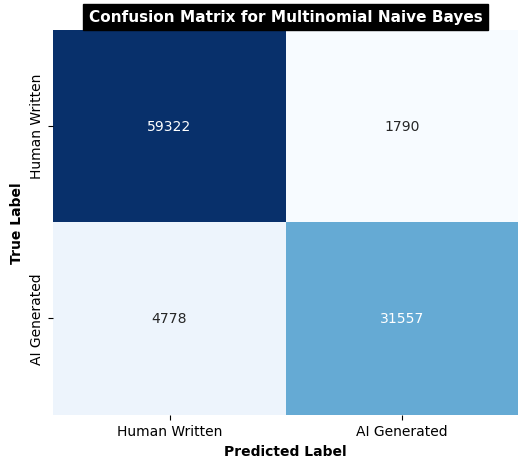

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     61112
         1.0       0.95      0.87      0.91     36335

    accuracy                           0.93     97447
   macro avg       0.94      0.92      0.93     97447
weighted avg       0.93      0.93      0.93     97447



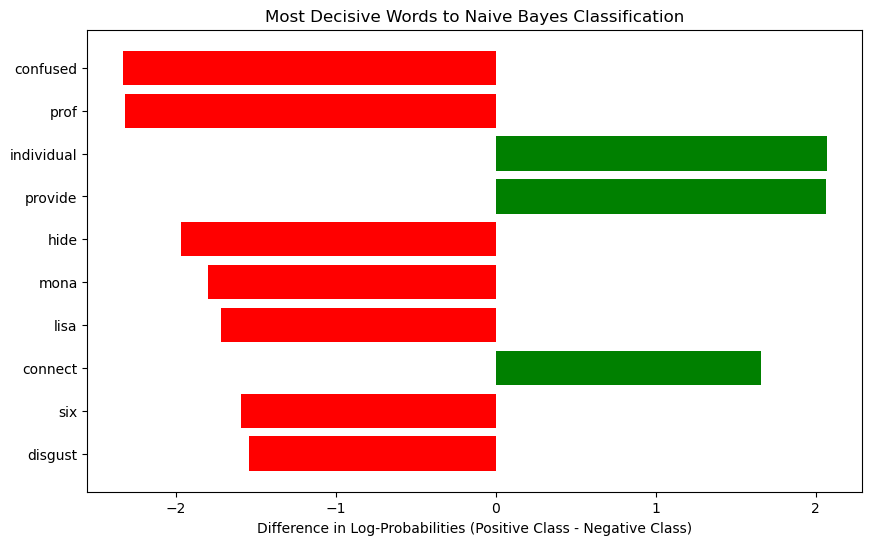

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

# To initialize the Multinomial Naive Bayes model
nb = MultinomialNB()

# To fit the model and predict the labels
nb.fit(X_train_tfidf, y_train)
y_pred_nb_train = nb.predict(X_train_tfidf)
y_pred_nb_test = nb.predict(X_test_tfidf)

# To print the accuracy of the model
print("Model: Multinomial Naive Bayes")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_nb_train) * 100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_nb_test) * 100:.2f}%")

# To generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Human Written', 'AI Generated'],
            yticklabels=['Human Written', 'AI Generated'])

plt.xlabel('Predicted Label', fontdict={'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('True Label', fontdict={'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('Confusion Matrix for Multinomial Naive Bayes',
          fontdict={'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.show()

# To print the classification report
print("Classification Report:\n" + classification_report(y_test, y_pred_nb_test))


feature_names = tf_idf.get_feature_names_out()

# Get log probabilities from the trained Naive Bayes model
log_probs = nb.feature_log_prob_
pos_class_log_probs = log_probs[1]  # Positive class (AI Generated)
neg_class_log_probs = log_probs[0]  # Negative class (Human Written)

# Identify non-zero word indices in one of the processed texts
processed_text = X_test_tfidf[0]  # Example: the first sample in the test set

# Extract non-zero indices and values from the sparse matrix
word_indices = np.nonzero(processed_text)[0]  # Get the indices of non-zero elements

# Get the actual words based on the indices
words_in_text = [feature_names[i] for i in word_indices]

# Calculate word contributions for both classes
word_contributions_pos = [pos_class_log_probs[i] for i in word_indices]
word_contributions_neg = [neg_class_log_probs[i] for i in word_indices]

# Combine words with their positive and negative class log-probabilities
word_contributions = list(zip(words_in_text, word_contributions_pos, word_contributions_neg))

# Sort words by the difference in log-probabilities (top decisive words)
word_contributions = sorted(word_contributions, key=lambda x: abs(x[1] - x[2]), reverse=True)

# Select the top 10 decisive words
word_contributions = word_contributions[:10]
words, _, _ = zip(*word_contributions)

# Plot the contributions of the top 10 decisive words
plt.figure(figsize=(10, 6))
pos_contributions = [c[1] for c in word_contributions]  # Positive class log-probs
neg_contributions = [c[2] for c in word_contributions]  # Negative class log-probs
contributions = np.array(pos_contributions) - np.array(neg_contributions)

# Color the bars: green for positive contribution, red for negative contribution
colors = ['green' if c > 0 else 'red' for c in contributions]
plt.barh(words, contributions, color=colors)
plt.xlabel('Difference in Log-Probabilities (Positive Class - Negative Class)')
plt.title('Most Decisive Words to Naive Bayes Classification')
plt.gca().invert_yaxis()
plt.show()

In [11]:
with open('naive_bayes.pkl', 'wb') as file:
    pickle.dump(nb, file)

Model: Logistic Regression
Training Accuracy: 98.96%
Test Accuracy: 98.92%


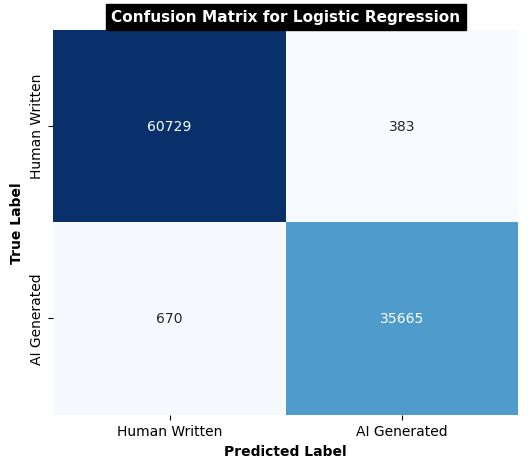

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     61112
         1.0       0.99      0.98      0.99     36335

    accuracy                           0.99     97447
   macro avg       0.99      0.99      0.99     97447
weighted avg       0.99      0.99      0.99     97447



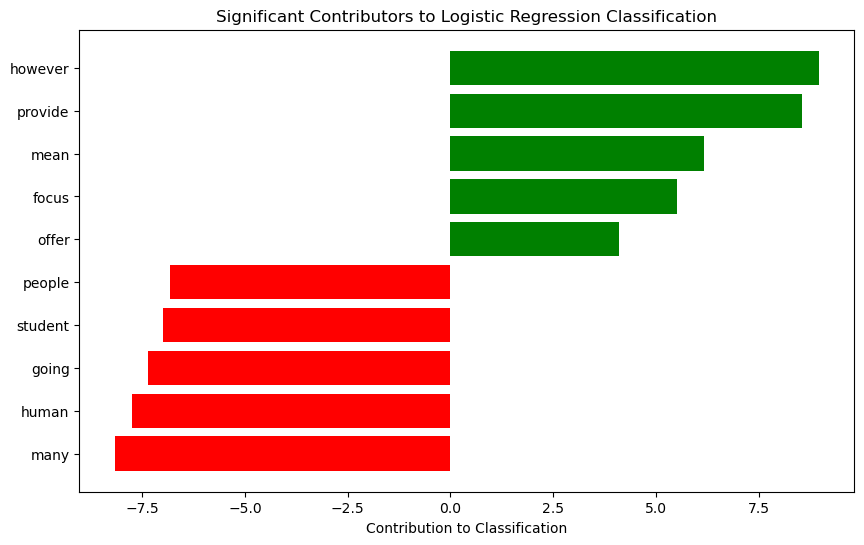

In [6]:
from sklearn.linear_model import LogisticRegression

# To initialize the Logistic Regression model
lr = LogisticRegression()

# To fit the model and predict the labels
lr.fit(X_train_tfidf, y_train)
y_pred_lr_train = lr.predict(X_train_tfidf)
y_pred_lr_test = lr.predict(X_test_tfidf)

# To print the accuracy of the model
print("Model: Logistic Regression")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_lr_train) * 100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr_test) * 100:.2f}%")

# To generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr_test)

plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False,
            xticklabels = ['Human Written', 'AI Generated'],
            yticklabels = ['Human Written', 'AI Generated'])

plt.xlabel('Predicted Label', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('True Label', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('Confusion Matrix for Logistic Regression', fontdict = {'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.show()

# To print the classification report
print("Classification Report:\n" + classification_report(y_test, y_pred_lr_test))

# Get feature names from the vectorizer
feature_names = tf_idf.get_feature_names_out()

# Get the coefficients from the trained Logistic Regression model
coef = lr.coef_[0]

# Identify non-zero word indices in one of the processed texts (first example in test set)
processed_text = X_test_tfidf[0]  # Using the first sample

# Extract non-zero indices from the dense matrix
word_indices = np.nonzero(processed_text)[0]  # Get the indices of non-zero elements

# Get the actual words based on the indices
words_in_text = [feature_names[i] for i in word_indices]

# Calculate word contributions based on the coefficients
word_contributions = [coef[i] for i in word_indices]

# Sort words by their contributions (largest contributors to the classification decision)
word_contributions = sorted(zip(words_in_text, word_contributions), key=lambda x: x[1], reverse=True)

# If there are more than 10 contributions, truncate to top 5 and bottom 5
if len(word_contributions) > 10:
    word_contributions_trunc = word_contributions[:5] + word_contributions[-5:]
    words, contributions = zip(*word_contributions_trunc)
else:
    words, contributions = zip(*word_contributions)

# Plot the contributions of the most significant words
plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in contributions]
plt.barh(words, contributions, color=colors)
plt.xlabel('Contribution to Classification')
plt.title('Significant Contributors to Logistic Regression Classification')
plt.gca().invert_yaxis()
plt.show()

In [13]:
with open('logistic_regression.pkl', 'wb') as file:
    pickle.dump(lr, file)

c:\Users\BP927MR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9675 - loss: 0.0819 - val_accuracy: 0.9927 - val_loss: 0.0228
Epoch 2/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - accuracy: 0.9935 - loss: 0.0192 - val_accuracy: 0.9947 - val_loss: 0.0165
Epoch 3/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9970 - val_loss: 0.0106
Epoch 4/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9979 - val_loss: 0.0076
Epoch 5/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9983 - val_loss: 0.0061
Epoch 6/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9988 - val_loss: 0.0053
Epoch 7/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9989 - val_loss: 0.0050
Epoch 8/10
9745/9745 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.9996 - loss:

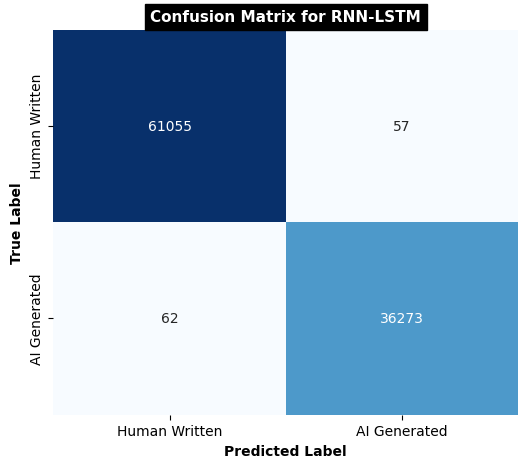

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     61112
         1.0       1.00      1.00      1.00     36335

    accuracy                           1.00     97447
   macro avg       1.00      1.00      1.00     97447
weighted avg       1.00      1.00      1.00     97447



In [14]:
# To reshape the data for RNN-LSTM input
X_train_rnn = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_test_rnn = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# To build and compile the RNN-LSTM Model
model = Sequential()
model.add(LSTM(64, input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences = False))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only = True, monitor = 'val_loss')

# To fit the model and predict the labels
history = model.fit(X_train_rnn, y_train, 
                    validation_split = 0.2, 
                    epochs = 10, 
                    batch_size = 32, 
                    callbacks = [early_stopping, model_checkpoint])

y_pred_prob = model.predict(X_test_rnn)
y_pred = (y_pred_prob > 0.5).astype(int)

# To print the accuracy of the model
print("Model: RNN-LSTM")
accuracy_train = model.evaluate(X_train_rnn, y_train)
accuracy_test = model.evaluate(X_test_rnn, y_test)
print(f"Training Accuracy: {accuracy_train[1]* 100:.4f}%")
print(f"Test Accuracy: {accuracy_test[1]* 100:.4f}%")

# To generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False,
            xticklabels = ['Human Written', 'AI Generated'],
            yticklabels = ['Human Written', 'AI Generated'])

plt.xlabel('Predicted Label', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.ylabel('True Label', fontdict = {'size': 10, 'weight': 'bold', 'color': 'black'})
plt.title('Confusion Matrix for RNN-LSTM', fontdict = {'size': 11, 'weight': 'bold', 'color': 'white', 'backgroundcolor': 'black'})
plt.show()

# To print the classification report
print("Classification Report:\n" + classification_report(y_test, y_pred))

In [15]:
model.save('RNN.h5')